# mesoSPIM PSF-analysis

## Experiment setup
- Mitutoyo BD 20Xt3.5/0.28  objective & MT-1 tube lens
- Photometrics Iris 15 camera
- 200-nm Fluorobright Yellow beads mounted in 2% agarose in CUBIC-R (n1.52) inside a 10x10x45 mm cuvette
- cuvette is in the air, with focus interpolation in z, if folder name specifies ot.
- thickness of high-RI medium in detection path 5 mm

### Tips and tricks
- LS tilt **and** tip relative to detection plane must be well aligned. Use the translation stage (mirror translation) for tilt alignment, and shims/adjustment screw for tip alignment. 
- For better LS tip/tilt alignment, go in and out of focus to visualize whole-field PSF degradation easier.
- **chamber** tip and tilt must be also aligned to advoid astigmatism

### On focus interpolation
Although focus interpolation can be useful in some situations, where stationary immersion chamber is undesired, it severely reduced z-resolution. In the G Plan Apo 20xt3.5 case, FWHM(Z) increases from 4 to 6.5 um and variance also increases. The reason is probably spherical aberration.

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, find_available_plugins
import time

In [2]:
from psf import plotPSF, getCenters, getPSF

### Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [51]:
from ipywidgets import interact
from ipywidgets import IntSlider

### Define parameters

`windowUm = [15, 15, 15]` defines a "window" volume in microns in which only a single bead can exist (for the bead to be included in the analysis, the volume has to contain a single bright maximum).

In [4]:
# Full FOV 
MAG = 20 # Nominal magniciation of te objective
TL_f_mm = 200 # TL focal distante (200 or 180 mm)
eff_MAG = MAG * TL_f_mm/200
UmPerPxLat = 4.25/eff_MAG
pxPerUmLat = 1/UmPerPxLat
pxPerUmAx = 1.0 # between z-planes
windowUm = [10, 10, 10] # 
options = {'pxPerUmLat':pxPerUmLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = 2000 #changed to abs, was relative: (0.05) 
options

{'pxPerUmLat': 4.705882352941177,
 'pxPerUmAx': 1.0,
 'windowUm': [10, 10, 10],
 'thresh': 2000}

In [5]:
#datafolder = "D:\\benchtopData\\PSF\\2022-12-16-Mitu20x-MT1-focus-interp\\exp20ms\\"
datafolder = "D:\\benchtopData\\PSF\\2022-12-16-Mitu20x-MT1-immersion\\exp20ms\\"
LENS_NAME = f"Mitutoyo G Plan Apo {MAG}x/0.28 TL MT1"
CAMERA = "Photometrics Iris 15"
sensor_dim_mm = (21.49, 12.61) # Iris 15
freq_Hz = 99.9
exp_ms = 20
wf_ms = 267
ETL = 'on'
experiment_key = f"{MAG}X_ETL-{ETL}-f{freq_Hz}Hz-exp{exp_ms}ms-wf{wf_ms}ms_fitCorrect" 
datafiles = {
    "20X_ETL-on-f99.9Hz-exp20ms-wf267ms_fitCorrect": datafolder + f"20x-5mmOil-right-etl-on.tif",
    "20X_ETL-off-f99.9Hz-exp20ms-wf267ms_fitCorrect": datafolder + f"20x-5mmOil-right-etl-off.tif",
}
experiment_key

'20X_ETL-on-f99.9Hz-exp20ms-wf267ms_fitCorrect'

### Load data

In [6]:
im = imread(datafiles[experiment_key], plugin='tifffile')[:100]
print(im.shape)
FOV_Y_um, FOV_X_um = im.shape[1] * UmPerPxLat, im.shape[2] * UmPerPxLat
print(FOV_Y_um, FOV_X_um)

(50, 5056, 2960)
1074.3999999999999 629.0


### Computation

In [7]:
start_time = time.time()
beads, maxima, centers, smoothed = getCenters(im, options)
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

findBeads() done: 479 found
centersM done
centerDists done
keepBeads() done: 358 found
getCenters() done: 358 found
Runtime:  73.65198063850403  s


In [8]:
start_time = time.time()
data = [getPSF(x, options) for x in beads]
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

Runtime:  0.9436800479888916  s


In [9]:
centers = pd.DataFrame(centers, columns=['Z','Y','X'])

In [10]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]
PSF = PSF.join(centers)

### Inspect results

In [11]:
PSF.head()

,FWHMlat,FWHMax,Max,Z,Y,X
0,1.318585,3.374934,36471,38,4800,299
1,1.293705,4.222790,34310,6,56,376
2,1.453053,3.904412,32230,22,4396,570
3,1.423180,3.335584,34078,36,3599,555
4,1.495269,3.352859,31520,39,4486,990


In [12]:
with open(datafolder + '/bead-stats.txt', 'w+') as f:
    s = f"""{experiment_key}
    \n#Beads: {len(PSF)} 
    \nMedian lateral FWHM (+/- std): {round(np.nanmedian(PSF['FWHMlat']),2)}  +/- {round(PSF['FWHMlat'].std(),2)} um
    \nMIN, MAX lateral FWHM: {round(PSF['FWHMlat'].min(),2)}, {round(PSF['FWHMlat'].max(),2)} um
    \nMedian axial FWHM  (+/- std): {round(np.nanmedian(PSF['FWHMax']),2)} +/- {round(PSF['FWHMax'].std(),2)} um
    \nMIN, MAX axial FWHM: {round(PSF['FWHMax'].min(),2)}, {round(PSF['FWHMax'].max(),2)} um
    """
    print(s); f.write(s)

20X_ETL-on-f99.9Hz-exp20ms-wf267ms_fitCorrect
    
#Beads: 358 
    
Median lateral FWHM (+/- std): 1.49  +/- 0.07 um
    
MIN, MAX lateral FWHM: 1.28, 1.85 um
    
Median axial FWHM  (+/- std): 3.98 +/- 0.67 um
    
MIN, MAX axial FWHM: 2.02, 5.69 um
    


### Plot axial FWHM vs. FOV

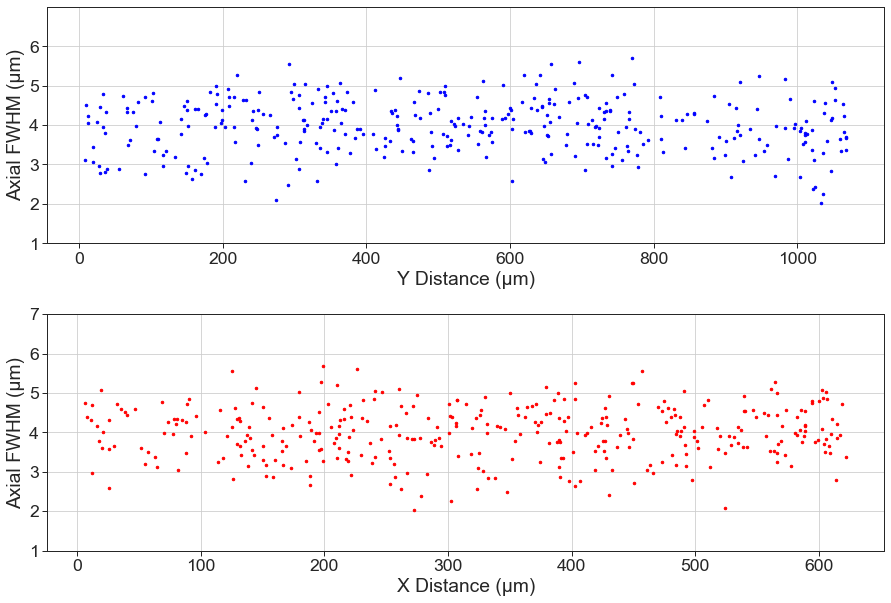

In [148]:
%matplotlib inline
YMIN, YMAX = 1, 7
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.b',ms=5)
subfigure0.set_ylim([YMIN,YMAX])
subfigure0.set_yticks(range(YMIN, YMAX))
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Axial FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.r',ms=5)
subfigure1.set_ylim([YMIN,YMAX])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Axial FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

In [149]:
fig.savefig(datafolder + f'/{experiment_key}-axialFWHM-along-axes.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-axialFWHM-along-axes.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

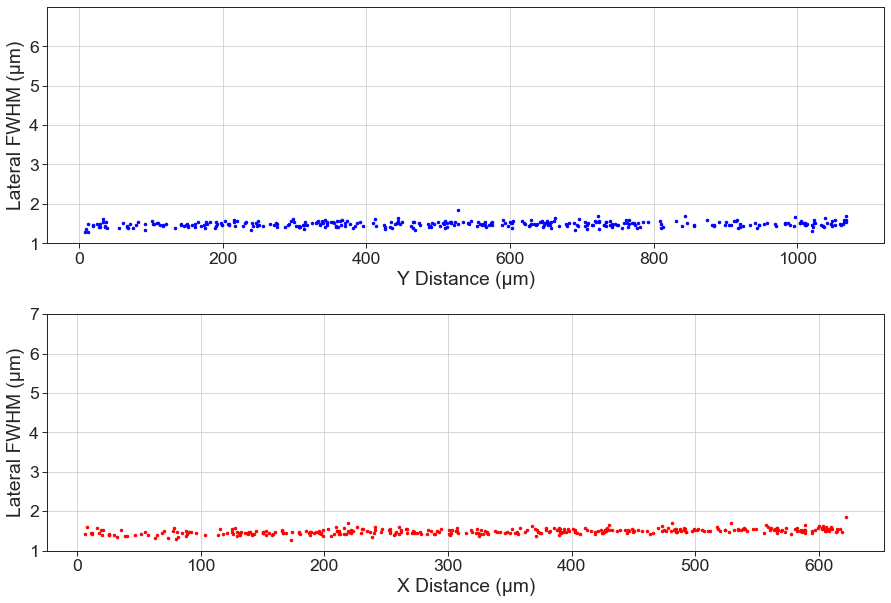

In [150]:
%matplotlib inline
YMIN, YMAX = 1, 7
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMlat'].tolist(),'.b',ms=5)
subfigure0.set_ylim([YMIN,YMAX])
subfigure0.set_yticks(range(YMIN, YMAX))
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Lateral FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMlat'].tolist(),'.r',ms=5)
subfigure1.set_ylim([YMIN,YMAX])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Lateral FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

In [151]:
fig.savefig(datafolder + f'/{experiment_key}-lateralFWHM-along-axes.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-lateralFWHM-along-axes.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

In [152]:
PSF.to_csv(datafolder + f'/{experiment_key}-.csv')

### Plot max projection and detected beads

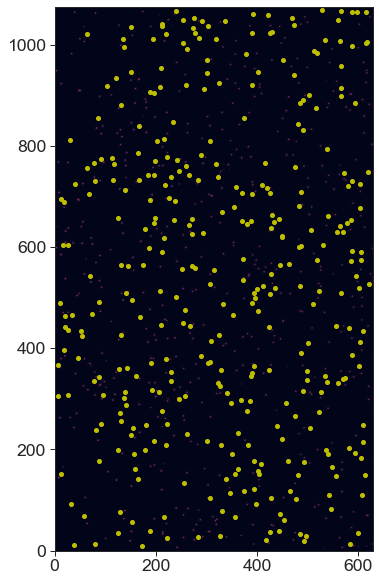

In [153]:
plt.figure(figsize=(10,10));
plt.imshow(smoothed, extent=(0, FOV_X_um, 0, FOV_Y_um))
plt.plot((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), 'y.', ms=8);
#plt.axis('off'); 

### Axial and lateral FWHM Histogram

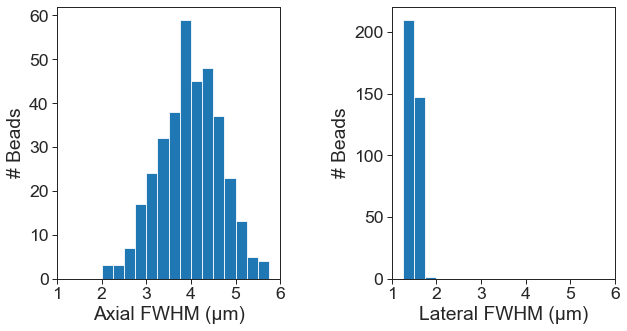

In [14]:
fig = plt.figure(figsize=(10,5))
subfigure0 = fig.add_subplot(121)
subfigure0.hist(PSF['FWHMax'].tolist(),20,range=(1,6))
subfigure0.set_xlim([1, 6])
subfigure0.set_xlabel('Axial FWHM (μm)')
subfigure0.set_xticks(range(1,7))
subfigure0.set_ylabel('# Beads')
subfigure1 = fig.add_subplot(122)
subfigure1.hist(PSF['FWHMlat'].tolist(),20,range=(1,6))
subfigure1.set_xlim([1, 6])
subfigure1.set_xticks(range(1,7))
subfigure1.set_xlabel('Lateral FWHM (μm)')
subfigure1.set_ylabel('# Beads')

plt.subplots_adjust(wspace = 0.5)

In [15]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-hist-axial-lateral.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-hist-axial-lateral.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

In [156]:
# manually exclude detections that are double-beads next to each other, see manual PSF check below
#exclude_IDs = [929, 2193]
#PSF_cleaned = PSF.drop(exclude_IDs)

### Overview Plots

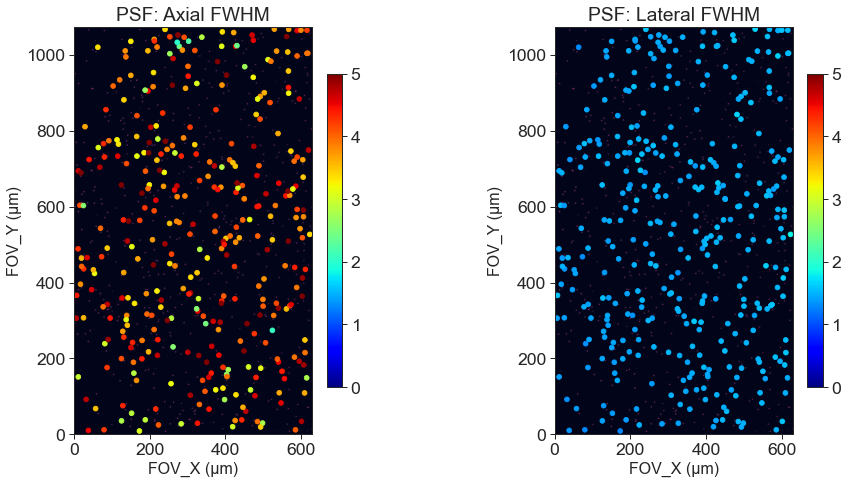

In [161]:
fig = plt.figure(figsize=(15,7.5));
cmap = 'jet'

subfigure0 = fig.add_subplot(121)
subfigure0.imshow(smoothed, extent=(0, FOV_X_um, 0, FOV_Y_um))
overlay0 = subfigure0.scatter((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), c=PSF['FWHMax'].tolist(),
                              cmap=cmap, vmin=0, vmax=5)
subfigure0.axis('on');
subfigure0.set_title('PSF: Axial FWHM')
subfigure0.set_ylabel('FOV_Y (μm)', fontsize=16)
subfigure0.set_xlabel('FOV_X (μm)', fontsize=16)
cbar0 = plt.colorbar(overlay0,fraction=0.044, pad=0.04)
#cbar0.set_label('Axial FWHM (μm)')


subfigure1 = fig.add_subplot(122)
subfigure1.imshow(smoothed, extent=(0, FOV_X_um, 0, FOV_Y_um));
overlay1 = subfigure1.scatter((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), c=PSF['FWHMlat'].tolist(), cmap=cmap, vmin=0, vmax=5);
subfigure1.axis('on');
subfigure1.set_title('PSF: Lateral FWHM')
subfigure1.set_ylabel('FOV_Y (μm)', fontsize=16)
subfigure1.set_xlabel('FOV_X (μm)', fontsize=16)
cbar1 = plt.colorbar(overlay1,fraction=0.044, pad=0.04)
#cbar1.set_label('Lateral FWHM (μm)')

plt.subplots_adjust(wspace = 0.35)

In [162]:
fig.savefig(datafolder + f'/{experiment_key}-Comparision-XYplot-jet-vmax5.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-Comparision-XYplot-jet-vmax5.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

## Plot XYZ projections of selected PSFs and fit

In [159]:
centerPSFs = PSF[PSF.FWHMax > 4.5]
centerPSFs.head()

,FWHMlat,FWHMax,Max,Z,Y,X
5,1.446632,4.689141,32503,37,3267,57
17,1.389258,4.594231,33399,12,1794,222
33,1.364667,4.518264,29964,42,48,182
38,1.437583,4.774637,31726,22,3312,323
48,1.463048,4.851719,29392,13,1176,428


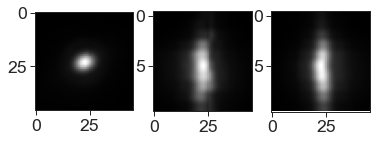

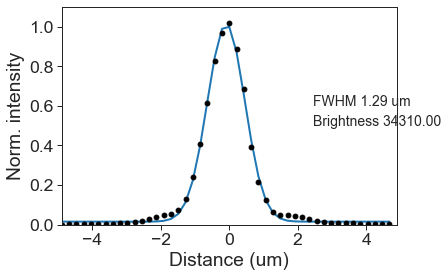

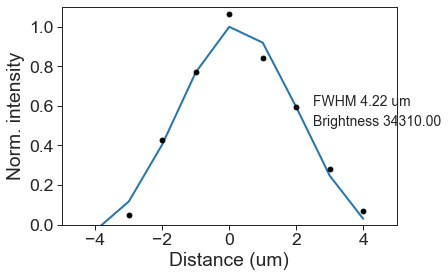

In [160]:
# Plot PSF with known ID
beadInd = 1
average = beads[beadInd]

fig, _axs = plt.subplots(nrows=1, ncols=3)
axs = _axs.flatten()

XYview = axs[0].imshow(average.mean(axis=0), cmap='gray');
XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
plt.show()

plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()